# 1. Makine Öğrenmesi ile Hastalık Tahmini

## 1.1 Gerekli kütüphanelerin ve verinin yüklenmesi

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

#modeller
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [31]:
veri_komb = pd.read_csv('veri_komb.csv', encoding='iso-8859-9', sep=",")
veri_komb.set_index('hastalik').head()

,baş ağrısı,bulanık görme,burun kanaması,düzensiz kalp ritmi,göğüs ağrısı,göğüste baskı,idrarda kan,nefes darlığı,ciltte kırmızlık,göz kapağında şişme,...,ruh hali değişimleri,çarpıntı,kanlı balgam,sürekli öksürük,ağız içinde yumru,ağızda uyuşma,boyunda yumru,gevşek diş,iyileşmeyen ağız yarası,koyu cilt
hastalik,,,,,,,,,,,,,,,,,,,,,
addison,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
addison,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
addison,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
addison,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
addison,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 1.2 Verinin Düzenlenmesi

1. Veri semptomlar ve tahmin edilmesi gereken hastalık olarak ayrıldı. 

2. Hastalık verisi string formatında olduğundan makine öğrenmesi algoritmasına girdi olarak verilebilmesi için float tipine dönüştürülmelidir. Bu dönüşüm **label encoder** kullanılarak yapıldı. Label encoder, n toplam hastalık sayısı olmak üzere 1'den n'e her bir hastalığı bir sayı ile eşleştirir. 

3. Veri eğitim (%70) ve test (%30) olmak üzere ayrıldı. 

In [32]:
semptomlar = veri_komb.iloc[:, 0:-1]
hastalik_string = veri_komb.hastalik

In [33]:
le = LabelEncoder()
le.fit(hastalik_string.tolist())
hastalik = le.transform(hastalik_string)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(semptomlar, hastalik, test_size=0.3, random_state=42)

## 1.3 Modellerin Kurulması

Tezimizde [en yaygın kullanılan 5 sınıflandırma modeli,](https://monkeylearn.com/blog/classification-algorithms/) random forest ve yapay sinir ağı modelini kuracağız. 

Son olarak modeller arasından chatbot uygulamamızda kullanmak üzere modelimizi seçip kaydedeceğiz. 

Kuracağımız modeller şunlardır:

1. Logistic Regression
2. Naive Bayes
3. K-Nearest Neighbors
4. Decision Tree
5. Random Forest
6. Support Vector Machines
7. Multi-layer Perceptron Classifier

1.4 bölümünde modeller arası başarı karşılaştırılacağından test, train accuracy değerleri her bir model için listede saklanacaktır.


In [35]:
train_accuracy = []
test_accuracy = []

### 1.3.1 Logistic Regression

Logistic regression iki sınıf içeren verileri sınıflandırmada kullanılır. Bizim verimiz ise 76 sınıf bulundurmaktadır. Bu yüzden bu sınıflandırma türünün ikiden fazla sınıf için genişletilmiş hali olan **multinomial logistic regression (softmax regression)** kullanılacaktır. 


Softmax regression her bir veri için çıktı olarak toplam değeri 1 olup 76 satırdan oluşan bir olasılık vektörü döndürür. En yüksek değer sınıflandırılan sınıf olur. 

Pipeline içerisinde sırasıyla StandardScaler, PCA ve logistic regression modelimiz bulunmaktadır.

StandardScaler ile aykırı (outlier) değerleri kaldırıp verilerin ortalamasını 0 standart sapmasını 1 yaparak ölçekleriz. 

Bunu yapmamız nedeni değişkenlerin modele eşit katkı yapmasını sağlamak ve yanlılık (bias) oluşumunun önüne geçmektir.

In [36]:
std_slc = StandardScaler()


PCA (Principal Component Analysis) orijinal verilerin varyansının çoğuna sahip yeni özellikler oluşturur böylece özelliklerimizin boyutunu azaltır. PCA özellikle verimiz fazla boyutlu olduğunda yaratacağı gürültü ve zorluğu aşmakta yani **curse of dimensionality** problemini aşmamızda bize yardımcı olur. 

In [37]:
pca = decomposition.PCA()

Modelimizi bir **pipeline** içinde kuruyoruz. Pipeline içerisinde sırasıyla hangi fonksiyonları çalıştırmamız gerektiğini belirtiyoruz. 



In [38]:
def pipeline(model):
  pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('model', model)])
  return pipe

In [39]:
logistic_reg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)

pipe = pipeline(logistic_reg)

In [40]:
pipe.fit(X_train, y_train)
y_predLR = pipe.predict(X_test)

In [41]:
lr_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
lr_test_accuracy = accuracy_score(y_test, y_predLR)

train_accuracy.append(lr_train_accuracy)
test_accuracy.append(lr_test_accuracy)

print("Train Accuracy: ", lr_train_accuracy)
print("Test Accuracy: ", lr_test_accuracy)

Train Accuracy:  0.9548979591836735
Test Accuracy:  0.9219047619047619


### 1.2.2 Naive Bayes

In [42]:
naive_bayes = GaussianNB()
pipe = pipeline(naive_bayes)

pipe.fit(X_train, y_train)
y_predNB = pipe.predict(X_test)

In [43]:
nb_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
nb_test_accuracy = accuracy_score(y_test, y_predNB)

train_accuracy.append(nb_train_accuracy)
test_accuracy.append(nb_test_accuracy)

print("Train Accuracy: ", nb_train_accuracy)
print("Test Accuracy: ", nb_test_accuracy)

Train Accuracy:  0.946734693877551
Test Accuracy:  0.9342857142857143


### 1.2.3 K-Nearest Neighbors

In [44]:
knn = KNeighborsClassifier()
pipe = pipeline(knn)

pipe.fit(X_train, y_train)
y_predKNN = pipe.predict(X_test)

In [45]:
knn_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
knn_test_accuracy = accuracy_score(y_test, y_predKNN)

train_accuracy.append(knn_train_accuracy)
test_accuracy.append(knn_test_accuracy)

print("Train Accuracy: ", knn_train_accuracy)
print("Test Accuracy: ", knn_test_accuracy)

Train Accuracy:  0.9420408163265306
Test Accuracy:  0.9080952380952381


### 1.2.4 Decision Tree

In [46]:
dt = DecisionTreeClassifier(splitter='best', criterion='entropy', min_samples_leaf=2)
pipe = pipeline(dt)

pipe.fit(X_train, y_train)
y_predDT = pipe.predict(X_test)

In [47]:
dt_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
dt_test_accuracy = accuracy_score(y_test, y_predDT)

train_accuracy.append(dt_train_accuracy)
test_accuracy.append(dt_test_accuracy)

print("Train Accuracy: ", dt_train_accuracy)
print("Test Accuracy: ", dt_test_accuracy)

Train Accuracy:  0.9493877551020408
Test Accuracy:  0.8723809523809524


### 1.2.5 Random Forest

In [48]:
rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=2)
pipe = pipeline(rf)

pipe.fit(X_train, y_train)
y_predRF = pipe.predict(X_test)

In [49]:
rf_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, y_predRF)

train_accuracy.append(rf_train_accuracy)
test_accuracy.append(rf_test_accuracy)

print("Train Accuracy: ", rf_train_accuracy)
print("Test Accuracy: ", rf_test_accuracy)

Train Accuracy:  0.9563265306122449
Test Accuracy:  0.9147619047619048


### 1.2.6 Support Vector Machines

In [50]:
svc = SVC()
pipe = pipeline(svc)

pipe.fit(X_train, y_train)
y_predSVC = pipe.predict(X_test)

In [51]:
svc_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
svc_test_accuracy = accuracy_score(y_test, y_predSVC)

train_accuracy.append(svc_train_accuracy)
test_accuracy.append(svc_test_accuracy)

print("Train Accuracy: ", svc_train_accuracy)
print("Test Accuracy: ", svc_test_accuracy)

Train Accuracy:  0.9344897959183673
Test Accuracy:  0.9195238095238095


### 1.2.7 MLP Classifier

In [52]:
mlp = MLPClassifier()
pipe = pipeline(mlp)

pipe.fit(X_train, y_train)
y_predMLP = pipe.predict(X_test)

In [53]:
mlp_train_accuracy = accuracy_score(y_train, pipe.predict(X_train))
mlp_test_accuracy = accuracy_score(y_test, y_predMLP)

train_accuracy.append(mlp_train_accuracy)
test_accuracy.append(mlp_test_accuracy)

print("Train Accuracy: ", mlp_train_accuracy)
print("Test Accuracy: ", mlp_test_accuracy)

Train Accuracy:  0.9563265306122449
Test Accuracy:  0.9157142857142857


## 1.4 Model Başarılarının Yorumlanması

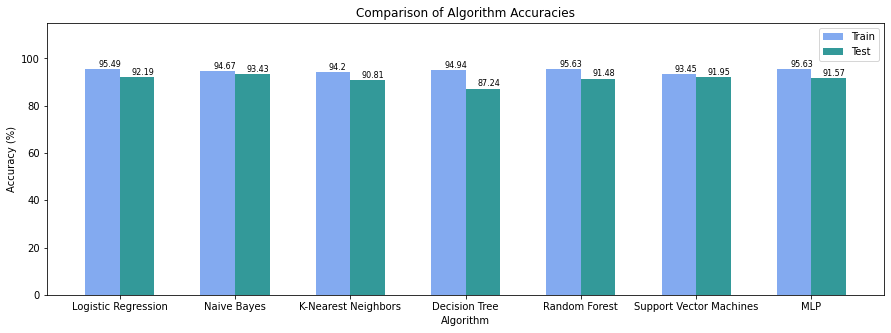

In [54]:
n_groups = 7
algorithms = ('Logistic Regression', 'Naive Bayes', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Support Vector Machines', 'MLP')
train_accuracy_perc = [i * 100 for i in train_accuracy]
test_accuracy_perc = [i * 100 for i in test_accuracy]

fig, ax = plt.subplots(figsize=(15, 5))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
rects1 = plt.bar(index, train_accuracy_perc, bar_width, alpha = opacity, color='Cornflowerblue', label='Train')
rects2 = plt.bar(index + bar_width, test_accuracy_perc, bar_width, alpha = opacity, color='Teal', label='Test')
plt.xlabel('Algorithm') # x axis label
plt.ylabel('Accuracy (%)') # y axis label
plt.ylim(0, 115)
plt.title('Comparison of Algorithm Accuracies') # plot title
plt.xticks(index + bar_width * 0.5, algorithms) # x axis data labels
plt.legend(loc = 'upper right') # show legend
for index, data in enumerate(train_accuracy_perc):
    plt.text(x = index - 0.035, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
for index, data in enumerate(test_accuracy_perc):
    plt.text(x = index + 0.25, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
plt.show()

Test verisi için accuracy oranlarına baktığımızda en başarılı modelin **Naive Bayes** olduğunu tespit ettik. Şimdi GridSearch kullanarak hiperparametre optimizasyonu gerçekleştireceğiz. Gaussian Naive Bayes için yalnızca var_smoothing parametresi optimize edilebildiğinden çeşitli değerler ile deniyoruz. 

In [55]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=naive_bayes, 
                 param_grid=params_NB, 
                 cv=2,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 2 folds for each of 100 candidates, totalling 200 fits


{'var_smoothing': 0.001873817422860383}

Hem train hem test verisi için ufak miktarda da olsa artma gözlemlenmiştir. 

In [59]:
print("Train Accuracy: ",  accuracy_score(y_train, gs_NB.predict(X_train)))
print("Test Accuracy: ", accuracy_score(y_test, gs_NB.predict(X_test)))

Train Accuracy:  0.9493877551020408
Test Accuracy:  0.9347619047619048


## 1.5 Seçilen Modelin Kaydedilmesi

In [60]:
filename = 'model.sav'
pickle.dump(gs_NB, open(filename, 'wb'))